In [20]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
import pandas as pd
import numpy as np

In [21]:
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2021, 2, 25)

In [22]:
btc = web.DataReader('BTC-USD', 'yahoo', start, end)
btc = btc[~btc.index.duplicated()]
eth = web.DataReader('ETH-USD', 'yahoo', start, end)
eth = eth[~eth.index.duplicated()]
ada = web.DataReader('ADA-USD', 'yahoo', start, end)
ada = ada[~ada.index.duplicated()]
bnb = web.DataReader('BNB-USD', 'yahoo', start, end)
bnb = bnb[~bnb.index.duplicated()]
dot = web.DataReader('DOT1-USD', 'yahoo', start, end)
dot = dot[~dot.index.duplicated()]

In [23]:
btc_len = btc.shape[0]
eth_len = eth.shape[0]
ada_len = ada.shape[0]
bnb_len = bnb.shape[0]
dot_len = dot.shape[0]

In [24]:
coins = pd.concat([btc['Close'], eth['Close'], ada['Close'], bnb['Close'], dot['Close']], axis=1)

In [25]:
coins.columns = ['BTC', 'ETH', 'ADA', 'BNB', 'DOT']
returns = coins/coins.shift(1)
logReturns = np.log(returns)

In [26]:
btc

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344
2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,67865420765,32127.267578
2021-01-03,34608.558594,32052.316406,32129.408203,32782.023438,78665235202,32782.023438
2021-01-04,33440.218750,28722.755859,32810.949219,31971.914062,81163475344,31971.914062
2021-01-05,34437.589844,30221.187500,31977.041016,33992.429688,67547324782,33992.429688
2021-01-06,36879.699219,33514.035156,34013.613281,36824.363281,75289433811,36824.363281
2021-01-07,40180.367188,36491.191406,36833.875000,39371.042969,84762141031,39371.042969
2021-01-08,41946.738281,36838.636719,39381.765625,40797.609375,88107519480,40797.609375
2021-01-09,41436.351562,38980.875000,40788.640625,40254.546875,61984162837,40254.546875


In [27]:
noOfPortfolios = 10000
weight = np.zeros((noOfPortfolios, 5))

expectedReturn = np.zeros(noOfPortfolios)
expectedVolatility = np.zeros(noOfPortfolios)
sharpeRatio = np.zeros(noOfPortfolios)

meanLogRet = logReturns.mean()
Sigma = logReturns.cov()

for k in range(noOfPortfolios):
    # generate random weight vector
    w = np.array(np.random.random(5))
    w = w / np.sum(w)
    weight[k,:] = w
    
    # exepcted log return
    expectedReturn[k] = np.sum(meanLogRet * w)

    # excpected volatility
    expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    
    # shapre ratio
    sharpeRatio[k] = expectedReturn[k]/expectedVolatility[k]
    

In [28]:
maxIndex = sharpeRatio.argmax()
random_alocs = weight[maxIndex,:]*100

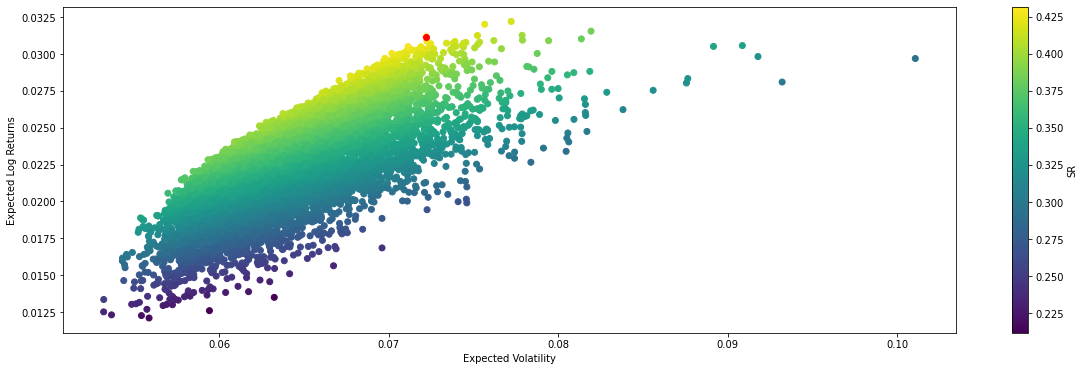

In [29]:
plt.figure(figsize=(20, 6))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], c='red')
plt.show()

In [30]:
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogRet*w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    SR = R/V
    return -1*SR

def checkSumToOne(w):
    return np.sum(w)-1

In [31]:
w0 = [0.25, 0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
constraints = ({'type':'eq', 'fun':checkSumToOne})

In [32]:
w_opt = minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints)
w_opt

     fun: -0.43660549699684414
     jac: array([ 6.01778179e-02,  9.01497565e-02,  1.36718154e-05, -1.31346285e-04,
        1.75338238e-04])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.32737577e-17, 0.00000000e+00, 5.74851793e-01, 2.68699174e-01,
       1.56449033e-01])

In [33]:
opt_alocs = w_opt.x*100

In [34]:
for coin, opt_aloc, random_aloc in zip(coins.columns, opt_alocs, random_alocs):
    print(f"Invest ({random_aloc:.1f}%) {opt_aloc:.1f}% in {coin}")

Invest (5.2%) 0.0% in BTC
Invest (1.4%) 0.0% in ETH
Invest (55.8%) 57.5% in ADA
Invest (24.7%) 26.9% in BNB
Invest (12.9%) 15.6% in DOT


In [35]:
rets = np.linspace(0, 0.07, 50)
volatility_opt = []

def minimizeMyVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    return V
    
def getReturn(w):
    w = np.array(w)
    R = np.sum(meanLogRet*w)
    return R
    
for ret in rets:
    constraints = ({'type':'eq', 'fun':checkSumToOne},
                   {'type':'eq', 'fun': lambda w: getReturn(w) - ret})
    opt = minimize(minimizeMyVolatility, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    volatility_opt.append(opt['fun'])
    
    
    

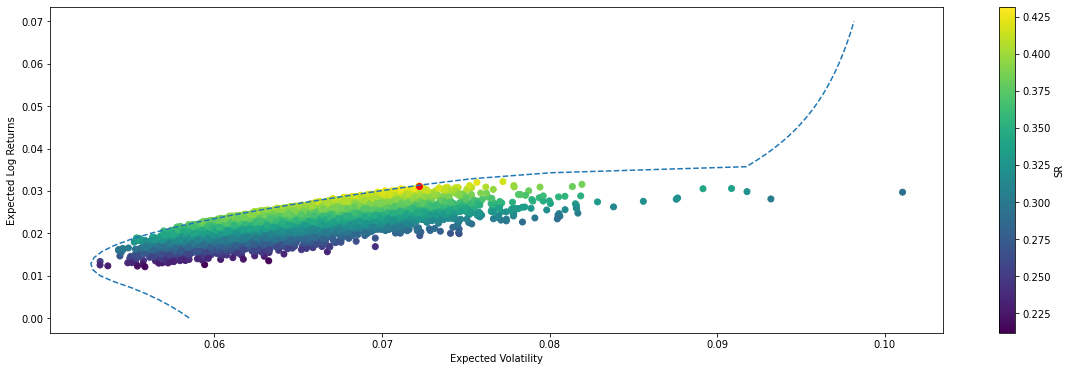

In [37]:
plt.figure(figsize=(20, 6))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], c='red')
plt.plot(volatility_opt, rets, '--')
plt.show()